In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# Use the Base class to reflect the database tables into ORM classes
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the classes to a variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session (link) from Python to the DB
session = Session(engine)

In [11]:
# Display the row's columns and data in dictionary format
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fd2ac08788>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [12]:
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fd2a8c25c8>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [13]:
# Retrieve the last 12 months of precipitation data and plot the results

# Total dates from the Measurement class
session.query(func.count(Measurement.date)).all()

[(19550)]

In [14]:
# Query the latest date 
latest_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_query

('2017-08-23')

In [15]:
# Extract string from query object
latest_date_string = np.ravel(latest_date_query)[0]
latest_date_string

'2017-08-23'

In [16]:
# Convert string to datetime using strptime()
latest_date_dt = dt.datetime.strptime(latest_date_string, '%Y-%m-%d')
latest_date_dt

datetime.datetime(2017, 8, 23, 0, 0)

In [17]:
# Parse out the year, month and day from the datetime object
latest_year = dt.datetime.strftime(latest_date_dt, '%Y')
latest_month = dt.datetime.strftime(latest_date_dt, '%m')
latest_day = dt.datetime.strftime(latest_date_dt, '%d')

In [18]:
# Calculate the date 1 year ago from the last data point in the database
year_before_date = dt.date(int(latest_year), int(latest_month), int(latest_day)) - dt.timedelta(days=365)
year_before_date

datetime.date(2016, 8, 23)

In [19]:
# Query the last 12 months of precipitation data
precipitation_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date >= year_before_date)
                  .order_by(Measurement.date)
                  .all())

In [20]:
# Convert query object to Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df.head(3)

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05


In [21]:
# Set the index to the date column andsort dataframe by date
sorted_precipitation_df = precipitation_df.set_index('date').sort_index(ascending = True)
sorted_precipitation_df.head(3)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05


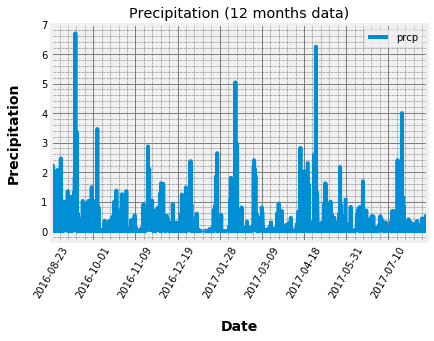

In [22]:
# Plotting the results
fig, ax = plt.subplots()

sorted_precipitation_df.plot(title = "Precipitation (12 months data)", ax=ax)

ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='1', color='grey')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax.set_ylabel("Precipitation", labelpad=20, weight='bold', size=14)
ax.set_xlabel("Date", labelpad=20, weight='bold', size=14)

plt.xticks(rotation=60)
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# Design a query to show how many stations are available in this dataset?

session.query(func.count(Station.id)).all()

[(9)]

In [25]:
station_list = session.query(Measurement.station).group_by(Measurement.station).all()
station_list

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

most_active_station = active_stations[0]
most_active_station

('USC00519281', 2772)

In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp_active_station = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

highest_temp_active_station = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

average_temp_active_station = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

print(f"Lowest Temperature: {lowest_temp_active_station[0][0]}\nHighest Temperature: {highest_temp_active_station[0][0]}\nAverage Temperature: {round((average_temp_active_station[0][0]),1)}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.7


In [28]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs_data = (session.query(Measurement.tobs)
                .filter(Measurement.date >= year_before_date)
                .filter(Measurement.station == most_active_station[0])
                .all())

In [29]:
# Convert query object to Pandas DataFrame
temp_obs_df = pd.DataFrame(temp_obs_data, columns = ["Temperature"])
temp_obs_df.head(3)

,Temperature
0,77.0
1,77.0
2,80.0


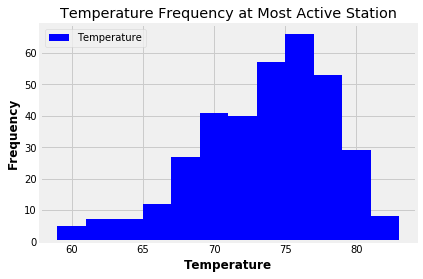

In [30]:
temp_obs_df.plot.hist(bins=12, title="Temperature Frequency at Most Active Station", color="blue", grid = True)

plt.ylabel('Frequency', weight='bold')
plt.xlabel('Temperature', weight='bold')
plt.show()

## Bonus Challenge

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = '2017-04-01'
trip_end = '2017-04-15'
trip_temp = calc_temps(trip_start, trip_end)
trip_temp

[(67.0, 74.47368421052632, 82.0)]

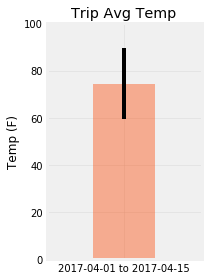

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_tmin = trip_temp[0][0]
trip_tavg = trip_temp[0][1]
trip_tmax = trip_temp[0][2]

peak_to_peak = trip_tmax-trip_tmin

plt.figure(figsize=(3,4))

x = f"{trip_start} to {trip_end}"
plt.bar(x, trip_tavg, yerr=peak_to_peak, color = 'orangered', alpha = .4)
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)
plt.tight_layout()

plt.show()

In [85]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Previous year's dates matching trip dates:
LY_trip_start = '2016-04-01'
LY_trip_end = '2016-04-15'

col_list = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

total_rain = (session.query(*col_list)
                .filter(Station.station == Measurement.station)
                .filter(Measurement.date >= LY_trip_start)
                .filter(Measurement.date <= LY_trip_end)
                .group_by(Station.station)).all()

In [90]:
# Convert query object to Pandas DataFrame
rain_df = pd.DataFrame(np.array(total_rain))

In [96]:
# Rename columns and sort by precipitation amount
rain_df = rain_df.rename(columns={0: "Station", 1: "Location", 2: "Total Precipitation", 3: "Latitude", 4: "Longitude", 5: "Elevation"})
rain_df.sort_values(by=["Total Precipitation"], ascending = False)

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.83,21.3331,-157.8025,152.4
4,USC00519281,"WAIHEE 837.5, HI US",2.6799999999999993,21.45167,-157.84888999999998,32.9
0,USC00513117,"KANEOHE 838.1, HI US",1.3500000000000003,21.4234,-157.8015,14.6
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.5,21.5213,-157.8374,7.0
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.3,21.33556,-157.71139,19.5
3,USC00517948,"PEARL CITY, HI US",0.04,21.3934,-157.9751,11.9
5,USC00519397,"WAIKIKI 717.2, HI US",0.03,21.2716,-157.8168,3.0


In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [131]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates

trip_start = '2017-04-01'
trip_end = '2017-04-15'

In [132]:
# Convert to datetime object and calculate duration
trip_start_dt = dt.datetime.strptime(trip_start, '%Y-%m-%d')
trip_end_dt = dt.datetime.strptime(trip_end, '%Y-%m-%d')

diff = trip_end_dt-trip_start_dt
duration = diff.days
duration

14

In [136]:
# Strip off the year and save a list of %m-%d strings 

date_list = [dt.datetime.strftime(trip_start_dt + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, duration+1)]
date_list

['04-01',
 '04-02',
 '04-03',
 '04-04',
 '04-05',
 '04-06',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15']

In [144]:
# Loop through the list of %m-%d strings and calculate the normals for each date

trip_normals = [daily_normals(date) for date in date_list]
trip_normals

[[(60.0, 71.87931034482759, 80.0)],
 [(53.0, 71.82142857142857, 79.0)],
 [(55.0, 72.2280701754386, 78.0)],
 [(58.0, 72.01639344262296, 78.0)],
 [(61.0, 72.28813559322033, 80.0)],
 [(67.0, 71.57142857142857, 77.0)],
 [(63.0, 71.10526315789474, 78.0)],
 [(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)]]

In [155]:
# Load the previous query results into a Pandas DataFrame 
trip_normals_array = [np.array(normal[0]) for normal in trip_normals]
normals_df = pd.DataFrame(trip_normals_array)
normals_df.head(2)

,0,1,2
0,60.0,71.879310,80.0
1,53.0,71.821429,79.0


In [161]:
# add the `trip_dates` range as the `date` index
normals_df["Date"] = date_list
normals_df = normals_df.set_index("Date")
normals_df = normals_df.rename(columns={0: "Tmin", 1: "Tavg", 2: "Tmax"})
normals_df.head(2)

,Tmin,Tavg,Tmax
Date,,,
04-01,60.0,71.879310,80.0
04-02,53.0,71.821429,79.0


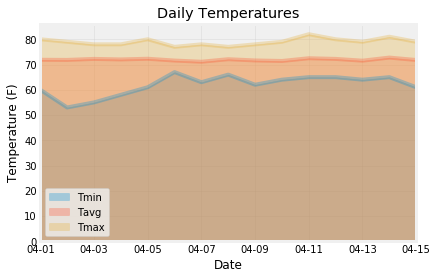

In [168]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha=.3)

plt.title('Daily Temperatures')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.3)

plt.show()